# 1. Importing libraries

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# 2. Load data

In [35]:
column_names = [
    "erythema", "scaling", "definite borders", "itching", "koebner phenomenon",
    "polygonal papules", "follicular papules", "oral mucosal involvement", "knee and elbow involvement",
    "scalp involvement", "family history", "melanin incontinence", "eosinophils in the infiltrate",
    "PNL infiltrate", "fibrosis of the papillary dermis", "exocytosis", "acanthosis",
    "hyperkeratosis", "parakeratosis", "clubbing of the rete ridges", "elongation of the rete ridges",
    "thinning of the suprapapillary epidermis", "spongiform pustule", "munro microabcess",
    "focal hypergranulosis", "disappearance of the granular layer", "vacuolisation and damage of basal layer",
    "spongiosis", "saw-tooth appearance of retes", "follicular horn plug", "perifollicular parakeratosis",
    "inflammatory monoluclear inflitrate", "band-like infiltrate", "Age", "class"
]

dermatology_data = pd.read_csv('dermatology/dermatology.data', header=None, names=column_names)

# 3. Data Preprocessing
## 3.1 Data replace and fill missing values

In [36]:
# Replacing the missing values with NaN
dermatology_data.replace("?", pd.NA, inplace=True)
dermatology_data['Age'] = pd.to_numeric(dermatology_data['Age'], errors='coerce')

# Filling the missing values in 'Age' with the median age
age_median = dermatology_data['Age'].median()
dermatology_data['Age'].fillna(age_median, inplace=True)

# Dropping the 'perifollicular parakeratosis' column
dermatology_data.drop('perifollicular parakeratosis', axis=1, inplace=True)

## 3.2 Splitting the data into train and test sets

In [37]:
# Splitting the data into train and test sets
train, test = train_test_split(dermatology_data, test_size=0.2, random_state=42)

# 4. Decision Tree Model
## 4.1 Tools Preparation
- calculate_entropy: Used to calculate the entropy of the data.
- split_dataset: Used to split the dataset based on the feature and feature value.

In [38]:
def calculate_entropy(data):
    """
    Calculate the entropy of the data.
    :param data: The dataset.
    :return: The entropy of the data.
    """
    labels = data.iloc[:, -1]
    label_counts = labels.value_counts()
    entropy = -sum((count/len(labels)) * np.log2(count/len(labels)) for count in label_counts)
    return entropy

def split_dataset(data, feature_index, value):
    """
    Split the dataset based on the feature and feature value.
    :param data: The dataset.
    :param feature_index: The index of the feature used to split the dataset.
    :param value: The value of the feature.
    :return: The dataset after splitting.
    """
    feature_name = data.columns[feature_index]
    reduced_data = data[data[feature_name] == value].drop(columns=[feature_name])
    return reduced_data

## 4.2 DecisionTree

In [39]:
class DecisionTree:
    def __init__(self, max_depth, min_info_gain):
        """
        Initialize the decision tree model.
        :param max_depth: The maximum depth of the tree which used to avoid over fitting.
        :param min_info_gain: The minimum information gain which used to avoid over fitting.
        """
        self.max_depth = max_depth
        self.min_info_gain = min_info_gain
        self.tree = None

    def choose_best_feature_to_split(self, data):
        """
        Choose the best feature to split the dataset, this method can be used to continuous and discrete features, like the age or the family history.
        :param data: The dataset.
        :return: The index of the best feature.
        """
        num_features = data.shape[1] - 1 
        base_entropy = calculate_entropy(data) 
        best_info_gain = 0.0 
        best_feature = -1 

        """
        To traverse all the features and find the best feature, each loop will calculate the information gain of the feature and update the best feature.
        """
        for i in range(num_features):
            feature_name = data.columns[i]
            unique_vals = set(data[feature_name])
            
            # Split the dataset based on the feature and calculate the new entropy.
            new_entropy = 0.0
            for value in unique_vals:
                sub_dataset = split_dataset(data, i, value)
                # Calculate The probability of the feature value.
                prob = len(sub_dataset) / float(len(data)) 
                # Update the new entropy.
                new_entropy += prob * calculate_entropy(sub_dataset)
            
            # Calculate the change of the entropy.
            info_gain = base_entropy - new_entropy
            # Update the best feature.
            if info_gain > best_info_gain and info_gain > self.min_info_gain:
                best_info_gain = info_gain
                best_feature = i

        return best_feature

    def build_tree(self, data, depth=0):
        """
        Use the ID3 algorithm to build the decision tree.
        :param data: The dataset.
        :param depth: The depth of the tree.
        :return: The decision tree.
        """
        labels = data.iloc[:, -1]
        if len(labels.unique()) == 1:
            return labels.iloc[0]
        if data.shape[1] == 1 or depth == self.max_depth:
            return labels.mode()[0]

        best_feature = self.choose_best_feature_to_split(data)
        if best_feature == -1:
            return labels.mode()[0]

        feature_name = data.columns[best_feature]
        tree = {feature_name: {}}
        for value in set(data[feature_name]):
            sub_data = split_dataset(data, best_feature, value)
            tree[feature_name][value] = self.build_tree(sub_data, depth + 1)

        return tree

    def fit(self, data):
        """
        Train the decision tree model.
        :param data: The dataset.
        """
        self.tree = self.build_tree(data)

    def predict_sample(self, tree, sample):
        """
        Predict the class of the signal sample.
        :param tree: The decision tree.
        :param sample: The single sample.
        :return: The predict result.
        """
        if not isinstance(tree, dict):
            return tree
        feature_index = list(tree.keys())[0]
        feature_value = sample[feature_index]
        
        if feature_value not in tree[feature_index]:
            # If the feature value is not in the tree, then return the mode of the labels.
            sub_tree = tree[feature_index][list(tree[feature_index].keys())[0]]
        else:
            sub_tree = tree[feature_index][feature_value]
        
        return self.predict_sample(sub_tree, sample)

    def predict(self, data):
        """
        Predict the class of the dataset.
        :param data: The dataset to be predicted.
        :return: The predict result.
        """
        predictions = data.apply(lambda x: self.predict_sample(self.tree, x), axis=1)
        return predictions

# 5. Model Training

In [40]:
tree = DecisionTree(max_depth=3, min_info_gain=0.1)
tree.fit(train)
predictions = tree.predict(test)

In [41]:
tree.tree

{'elongation of the rete ridges': {0: {'Age': {7.0: 6,
    8.0: 6,
    9.0: 6,
    10.0: {'follicular papules': {0: 2, 2: 6, 3: 6}},
    12.0: {'itching': {0: 4, 1: 6}},
    13.0: 6,
    15.0: 2,
    16.0: {'itching': {1: 2, 2: 4, 3: 3}},
    17.0: 4,
    18.0: {'scaling': {1: 4, 2: 3}},
    19.0: 2,
    20.0: {'definite borders': {0: 2, 1: 2, 2: 4}},
    21.0: {'erythema': {1: 4, 2: 2}},
    22.0: {'polygonal papules': {0: 4, 2: 3, 3: 3}},
    23.0: {'scaling': {1: 3, 2: 2}},
    25.0: {'spongiosis': {0: 3, 1: 4, 2: 2, 3: 2}},
    26.0: 3,
    27.0: {'parakeratosis': {0: 3, 1: 4, 2: 2}},
    28.0: 3,
    30.0: {'koebner phenomenon': {0: 2, 1: 3, 2: 4}},
    31.0: {'erythema': {1: 4, 3: 2}},
    32.0: {'itching': {0: 4, 2: 3, 3: 3}},
    33.0: 2,
    34.0: {'koebner phenomenon': {0: 2, 1: 4, 3: 3}},
    35.0: {'itching': {0: 4, 1: 4, 2: 2, 3: 3}},
    36.0: {'polygonal papules': {0: 2, 2: 3, 3: 3}},
    37.0: 3,
    38.0: 3,
    40.0: {'band-like infiltrate': {0: 2, 1: 5, 2: 3, 3: 3}},

# 6. Model Evaluation
## 6.1 Accuracy
I will calculate the accuracy of the model.
Accuracy is calculated as follows:
$$\( \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} \times 100 \) $$
Where:
- $\( \text{Number of correct predictions} \)$ is the number of correct predictions.
- $\( \text{Total number of predictions} \)$ is the number of all predictions.
- $\( \text{Accuracy} \)$ is the accuracy of the model.
- I will use the function below to calculate the accuracy of the model.

In [42]:
def accuracy(y_true, y_pred):
    """
    The accuracy function is used to compute the accuracy of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the accuracy of the model
    """
    return np.sum(y_true == y_pred) / len(y_true) * 100

print("Accuracy: {:.2f}%".format(accuracy(test.iloc[:, -1], predictions)))

Accuracy: 67.57%


## 6.2 Modify the MAX Depth

In [43]:
tree1 = DecisionTree(max_depth=1, min_info_gain=0.1)
tree1.fit(train)
predictions1 = tree1.predict(test)
print("Accuracy: {:.2f}%".format(accuracy(test.iloc[:, -1], predictions1)))

tree2 = DecisionTree(max_depth=2, min_info_gain=0.1)
tree2.fit(train)
predictions2 = tree2.predict(test)
print("Accuracy: {:.2f}%".format(accuracy(test.iloc[:, -1], predictions2)))

tree3 = DecisionTree(max_depth=3, min_info_gain=0.1)
tree3.fit(train)
predictions3 = tree3.predict(test)
print("Accuracy: {:.2f}%".format(accuracy(test.iloc[:, -1], predictions3)))

tree4 = DecisionTree(max_depth=4, min_info_gain=0.1)
tree4.fit(train)
predictions4 = tree4.predict(test)
print("Accuracy: {:.2f}%".format(accuracy(test.iloc[:, -1], predictions4)))

Accuracy: 59.46%
Accuracy: 60.81%
Accuracy: 67.57%
Accuracy: 66.22%


## 6.3 Modify the MIN Info Gain

In [44]:
tree1 = DecisionTree(max_depth=3, min_info_gain=0.1)
tree1.fit(train)
predictions1 = tree1.predict(test)
print("Accuracy: {:.2f}%".format(accuracy(test.iloc[:, -1], predictions1)))

tree2 = DecisionTree(max_depth=3, min_info_gain=0.3)
tree2.fit(train)
predictions2 = tree2.predict(test)
print("Accuracy: {:.2f}%".format(accuracy(test.iloc[:, -1], predictions2)))

tree3 = DecisionTree(max_depth=3, min_info_gain=0.9)
tree3.fit(train)
predictions3 = tree3.predict(test)
print("Accuracy: {:.2f}%".format(accuracy(test.iloc[:, -1], predictions3)))

tree4 = DecisionTree(max_depth=3, min_info_gain=1.2)
tree4.fit(train)
predictions4 = tree4.predict(test)
print("Accuracy: {:.2f}%".format(accuracy(test.iloc[:, -1], predictions4)))

Accuracy: 67.57%
Accuracy: 66.22%
Accuracy: 41.89%
Accuracy: 41.89%


# 6.4 Confusion Matrix

Recall: [0.87096774 0.55555556 0.61538462 0.25       0.7        0.33333333]
Precision: [1.         0.27777778 0.66666667 0.28571429 0.875      0.5       ]
F1 Score: [0.93103448 0.37037037 0.64       0.26666667 0.77777778 0.4       ]


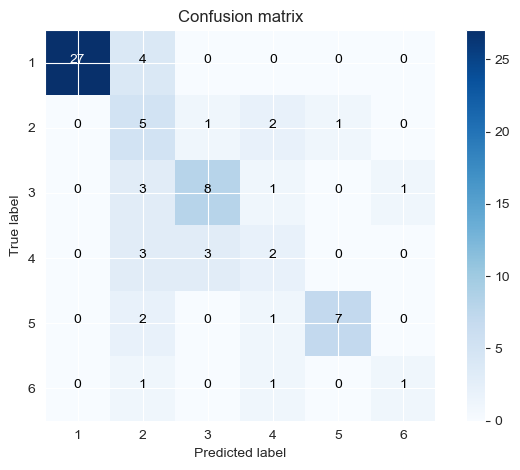

In [45]:
def confusion_matrix(y_true, y_pred):
    """
    The confusion matrix function is used to compute the confusion matrix of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the confusion matrix of the model
    """
    labels = np.unique(y_true)
    matrix = np.zeros((len(labels), len(labels)))
    for i in range(len(labels)):
        for j in range(len(labels)):
            matrix[i, j] = np.sum((y_true == labels[i]) & (y_pred == labels[j]))
    
    true_positives = np.diag(matrix)
    false_positives = np.sum(matrix, axis=0) - true_positives
    false_negatives = np.sum(matrix, axis=1) - true_positives
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * precision * recall / (precision + recall)
    
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1_score}")
    return matrix

def plot_confusion_matrix(cm, classes):
    """
    The plot_confusion_matrix function is used to plot the confusion matrix of the model.
    :param cm: the confusion matrix
    :param classes: the class labels
    """
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(int(cm[i, j])),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(confusion_matrix(test.iloc[:, -1], predictions), classes=np.unique(test.iloc[:, -1]))